In [1]:
import os
import torch
import helpers
import numpy as np 
import pandas as pd
from apex import amp
import torch.nn as nn
import pretrainedmodels
import albumentations as A
from sklearn import metrics
from torch.nn import functional as F
from models import SEResNext50_32x4d,SEResNeXt101_32x4d
from efficientnet_pytorch import EfficientNet
from Dataset import VehicleTrainDataset, VehicleTrainDataset2
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
pd.read_csv("input/sample_submission.csv").head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,0
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [3]:
def Inference(data_loader, model, device, use_tpu=False):
        model.eval()
        final_predictions = []
        with torch.no_grad():
            tk0 = tqdm(data_loader, total=len(data_loader), disable=use_tpu)
            for b_idx, data in enumerate(tk0):
                for key, value in data.items():
                    data[key] = value.to(device)
                predictions, _ = model(**data)
                predictions = predictions.cpu()
                final_predictions.append(predictions)
        return final_predictions

In [4]:
def Inference2(data_loader, model, device, use_tpu=False):
        model.eval()
        final_predictions = []
        with torch.no_grad():
            tk0 = tqdm(data_loader, total=len(data_loader), disable=use_tpu)
            for b_idx, data in enumerate(tk0):
                for key, value in data.items():
                    data[key] = value.to(device)
                targets = data["targets"].to(device).float()
                images = data["image"].to(device).float()

                out = model(images)
                predictions = out.cpu()
                final_predictions.append(predictions[:,1].view(-1,1))
        return final_predictions

In [5]:
def get_net():
    net = EfficientNet.from_name('efficientnet-b6')
    net._fc = nn.Linear(in_features=2304, out_features=2, bias=True)
    return net

net = get_net()

In [6]:
def predict(fold):
    test_data_path = "input/images/images/"
    df = pd.read_csv("input/test.csv")
    device = "cuda"
    model_path=f"Output/SEResNeXt101_32x4d_{fold}.pth"

    def test_transforms():
            return A.Compose(
        [
            A.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225), max_pixel_value = 255., always_apply = True)
#             ToTensorV2(p=1.0),
        ]
    )

    images = df.image_names.values.tolist()
    targets = np.zeros(len(images))
    df["emergency_or_not"] = targets

    testset = VehicleTrainDataset(df, image_dir = test_data_path,
                                         transforms = test_transforms())

    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=16, shuffle=False, num_workers=4
    )

    model = SEResNeXt101_32x4d(pretrained = None)
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    predictions = Inference(test_loader, model, device=device)
    predictions = np.vstack(([i.cpu() for i in predictions])).ravel()

    return predictions

In [7]:
# test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
# test_preds1 = np.zeros((len(test_dataset), 1))
# tk0 = tqdm(test_data_loader)
# for i, x_batch in enumerate(tk0):
#     x_batch = x_batch["image"]
#     pred = model(x_batch.to(device))
#     test_preds1[i * 32:(i + 1) * 32] = pred.detach().cpu().squeeze().numpy().ravel().reshape(-1, 1)

In [8]:
p1 = predict(0)
p2 = predict(1)
p3 = predict(2)
# p4 = predict(3)
# p5 = predict(4)

100%|██████████| 45/45 [00:05<00:00,  8.80it/s]


In [9]:
predictions = (p1+ p2 + p3) /3
sample = pd.read_csv("input/sample_submission.csv")
preds = [0 if i<0.5 else 1 for i in predictions]
sample.loc[:, "emergency_or_not"] = preds
sample.to_csv(f"submission_SEResNeXt101_32x4d.csv", index=False)
sample.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.canvas.print_figure(bytes_io, **kw)


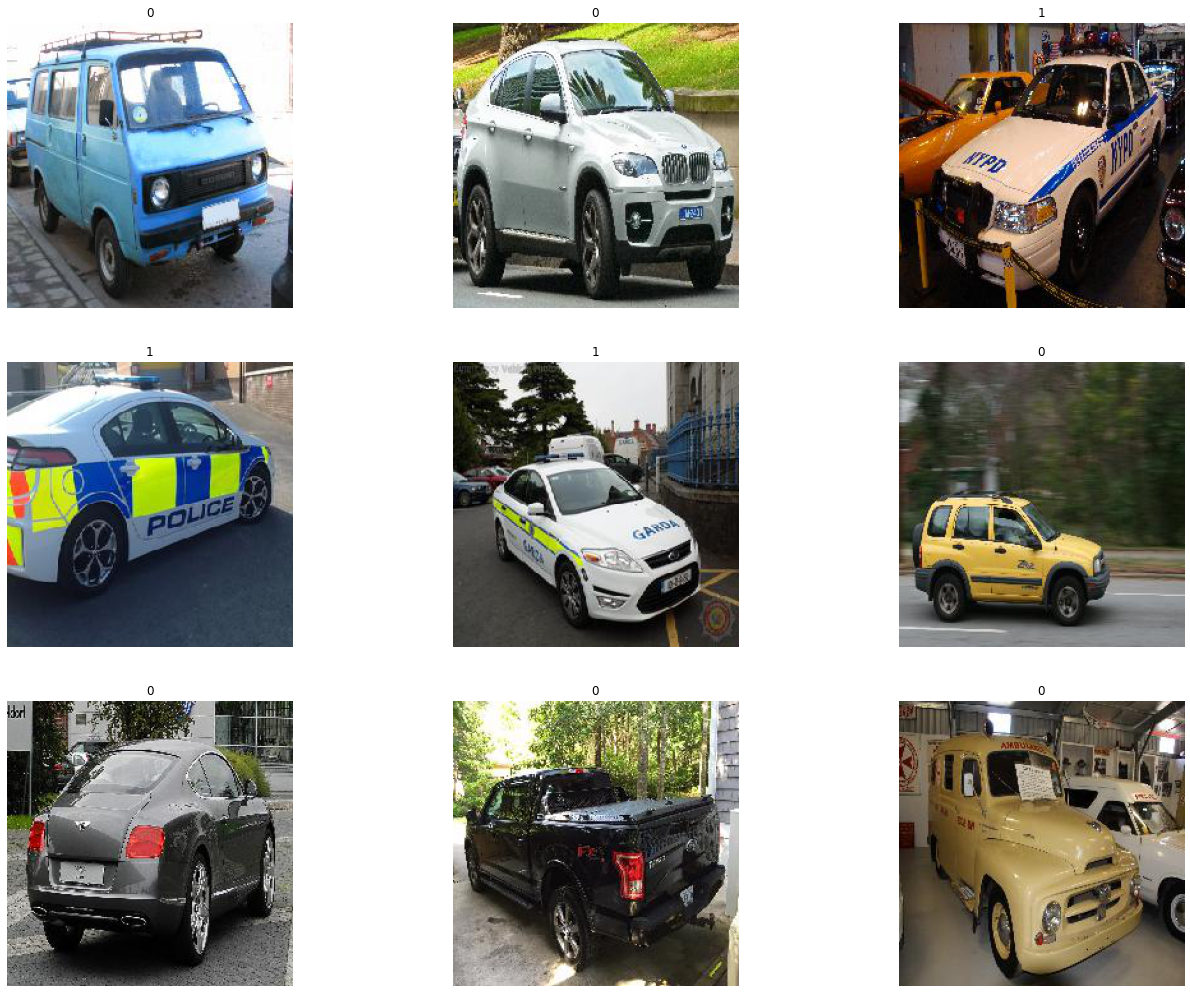

In [10]:
images = []
targets = []
s = sample.sample(16)
for i in range(16):
    tgt = s.emergency_or_not.iloc[i]
    img = s.image_names.iloc[i]
    images.append(img)
    targets.append(tgt)

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

fig, axs = plt.subplots(3,3,figsize = (23,18), constrained_layout=True, tight_layout = True)
axs = trim_axs(axs, 16)
for i, ax in enumerate(axs):
    single_image = images[i]
    single_target = targets[i]
    ax.title.set_text(f"{single_target}")

    ax.set_axis_off()
    image = Image.open(f"input/images/images/{single_image}")
    image = image.convert('RGB')
    image = np.array(image)
    ax.imshow(image)

In [17]:
submission1 = sample.copy()
effdet = pd.read_csv("submission_EfficientNet.csv")
ser = pd.read_csv("submission_SEResNeXt101_32x4d.csv")
submission1['emergency_or_not'] = ser['emergency_or_not']*0.8 + effdet['emergency_or_not']*0.2

In [18]:
submission1.head()

,image_names,emergency_or_not
0,1960.jpg,0.0
1,668.jpg,1.0
2,2082.jpg,0.0
3,808.jpg,1.0
4,1907.jpg,0.0


In [19]:
submission1['emergency_or_not'] = [0 if i < 0.5 else 1 for i in submission1['emergency_or_not']]

In [20]:
submission1['emergency_or_not'].unique()

array([0, 1])

In [21]:
submission1.to_csv("submission_Blend.csv", index = False)